# Setup

In [1]:
import time
import json
import math
import spacy
import numpy as np
import pandas as pd
import seaborn as sn
import networkx as nx
import sklearn.metrics as skm
import matplotlib.pyplot as plt 

from pprint import pprint
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preprocessing

In [2]:
predictions_path = '../out/predictions_afp.csv'
predictions = pd.read_csv(predictions_path)
# Dropping all docs without a true label
no_label = predictions[predictions['true'].isna()]
print('Initial  #', len(predictions))
print('no_label #', len(no_label))
predictions.drop(index=no_label.index, inplace=True)
print('Total    #', len(predictions), '\n')
predictions.head(2)

Initial  # 125516
no_label # 3542
Total    # 121974 



id      true  ... gsdmm_topic_2 gsdmm_score_2
1   1  13000000  ...             2  0.000000e+00
2   2  11000000  ...             5  1.009442e-12

[2 rows x 28 columns]

In [0]:
models   = ['lda', 'lftm', 'ntm', 'gsdmm']
n_topics = 17
topics   = range(n_topics)
labels   = sorted(set([label for labels in predictions['true'].unique() for label in labels.split(' ')]))
n_labels = len(labels)
n_preds  = 1

In [0]:
for model in models:
  ! wget -q ../out/{model}_topics_afp.json

In [5]:
 reverse_label_ids = {0: "arts_culture_entertainment",
                      1: "crime_law_justice", 
                      2: "disaster_accident", 
                      3: "economy_business_finance", 
                      4: "education", 
                      5: "environmental_issue", 
                      6: "health", 
                      7: "human_interest", 
                      8: "labour", 
                      9: "lifestyle_leisure", 
                      10: "politics", 
                      11: "religion_belief", 
                      12: "science_technology", 
                      13: "social_issue", 
                      14: "sport", 
                      15: "unrest_conflicts_war", 
                      16: "weather"}
label_ids = {label:i for i, label in reverse_label_ids.items()}
label_ids

{'arts_culture_entertainment': 0,
 'crime_law_justice': 1,
 'disaster_accident': 2,
 'economy_business_finance': 3,
 'education': 4,
 'environmental_issue': 5,
 'health': 6,
 'human_interest': 7,
 'labour': 8,
 'lifestyle_leisure': 9,
 'politics': 10,
 'religion_belief': 11,
 'science_technology': 12,
 'social_issue': 13,
 'sport': 14,
 'unrest_conflicts_war': 15,
 'weather': 16}

In [6]:
codes_to_labels = lambda s: ' '.join(reverse_label_ids[int(c[:2]) - 1] for c in s.split(' '))
labels_to_ids   = lambda s: ' '.join(str(label_ids[l]) for l in s.split(' '))
predictions['code'] = predictions['true']
predictions['true'] = predictions['code'].apply(codes_to_labels)
predictions['label_id'] = predictions['true'].apply(labels_to_ids)
# predictions['label_id'] = [label_ids[label] for label in predictions['true']]
predictions[['id', 'code', 'true', 'label_id']].tail(5)

id  ... label_id
125511  125511  ...       15
125512  125512  ...      0 7
125513  125513  ...      0 1
125514  125514  ...  13 7 10
125515  125515  ...    10 15

[5 rows x 4 columns]

In [7]:
docs_per_label = Counter([label for labels in predictions['true'] for label in labels.split(' ')])
docs_per_label.most_common()

[('politics', 47277),
 ('sport', 36901),
 ('economy_business_finance', 31042),
 ('unrest_conflicts_war', 21140),
 ('crime_law_justice', 16977),
 ('arts_culture_entertainment', 8586),
 ('social_issue', 7609),
 ('disaster_accident', 5893),
 ('human_interest', 4159),
 ('environmental_issue', 4036),
 ('science_technology', 3502),
 ('religion_belief', 3081),
 ('lifestyle_leisure', 3044),
 ('labour', 2570),
 ('health', 2535),
 ('weather', 1159),
 ('education', 734)]

In [8]:
predictions['true'].apply(lambda l: len(l.split(' '))).max()

15

In [9]:
for l,c in docs_per_label.most_common():
  print(str.ljust(l, 30), c)

politics                       47277
sport                          36901
economy_business_finance       31042
unrest_conflicts_war           21140
crime_law_justice              16977
arts_culture_entertainment     8586
social_issue                   7609
disaster_accident              5893
human_interest                 4159
environmental_issue            4036
science_technology             3502
religion_belief                3081
lifestyle_leisure              3044
labour                         2570
health                         2535
weather                        1159
education                      734


# Voting for topics

**Input:** 
* `n_topics`: number of topics 
* `n_preds`: number of predictions per document 
* `models`: list of trained TMs names 
* `predictions[label_id, tm_topic_k, tm_score_k]`: top *n_topics* predicted topic ids and the prediction confidence for each document with its ground truth label 

**Output:** 
* `probs[model, label_j, topic_i]`: sum of contributions (scores) from all document to the likelihood that topic T_i maps to label L_j 
* `d_probs[model, label_j, topic_i]`: sum of contributions (scores) from all document to the likelihood that topic T_i maps to label L_j, dilluted to account for the number of labels a document has
* `votes[model, label_j, topic_i]`: number of such contributions 

In [10]:
%%time
probs    = {model: {l: {t: 0. for t in topics} for l in range(n_labels)} for model in models}
votes    = {model: {l: {t: 0. for t in topics} for l in range(n_labels)} for model in models}
q_probs  = {model: {l: {t: 0. for t in topics} for l in range(n_labels)} for model in models}

for i, doc in predictions.iterrows():
  for model in models:
    gt_labels = [int(l) for l in doc['label_id'].split(' ')]
    for k in range(n_preds):
      t, p = doc[f'{model}_topic_{k}'], doc[f'{model}_score_{k}']
      for j, label in enumerate(gt_labels):
        if int(t) >= 0: # sometimes the model outputs -1, we discard those results
          probs[model][label][t]   += p 
          q_probs[model][label][t] += p / (j+1)
          votes[model][label][t]   += 1 if p > 0 else 0 # we only count the contribution if it's positive

CPU times: user 29.7 s, sys: 42.2 ms, total: 29.7 s
Wall time: 29.8 s


In [11]:
# Example : the score for LDA's topic_13 ('atheist, morality, moral, god,..') to be mapped to label_0 ("alt.atheism") 
print("probs['lda'][0][13] =", probs['lda'][0][13])

probs['lda'][0][13] = 513.7521420170635


# Finding the Mapping

**Input:** 
* `probs[model, label_j, topic_i]` and `votes[model, label_j, topic_i]`: from previous block
* `docs_per_label`: number of docs per label (for normalization)

**Output:** 
* `topic_dfs[model, scoring_model]`: Score matrices for each Label/Topic potential matching for all LMs using different counting/normalization options (sorted so that the label with the largest number of mapped topics is first for better visualization)
* visualizations for each LM/scoring methods in matrices
* `topic_mappings[model, scoring_model, topic]`: the mapping from topics to label_ids per LM/scoring 
* `reverse_topic_mappings[model, scoring_model, label_id]`: the mapping from label_id to a list of topics per LM/scoring method

CPU times: user 5.82 s, sys: 2.37 s, total: 8.19 s
Wall time: 5.63 s


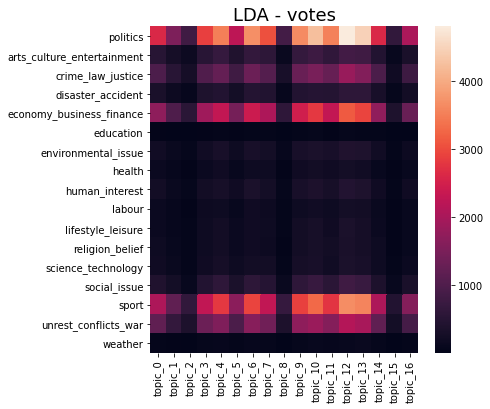

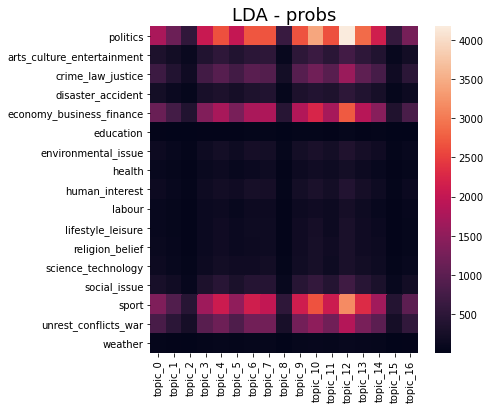

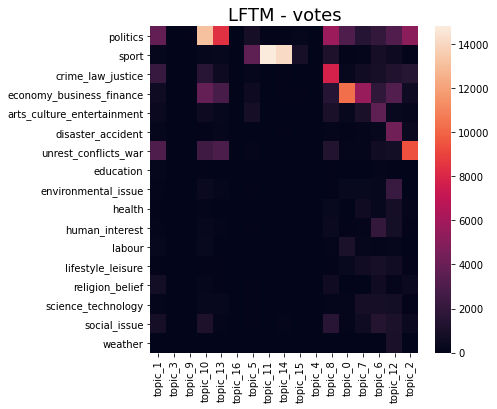

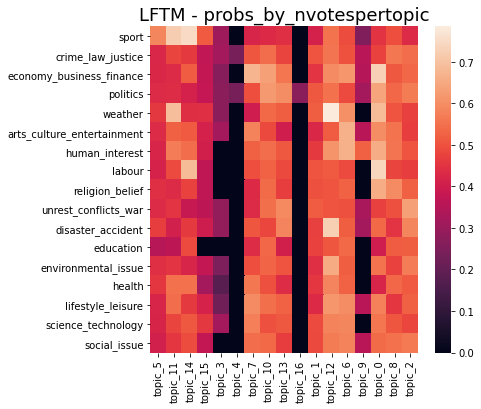

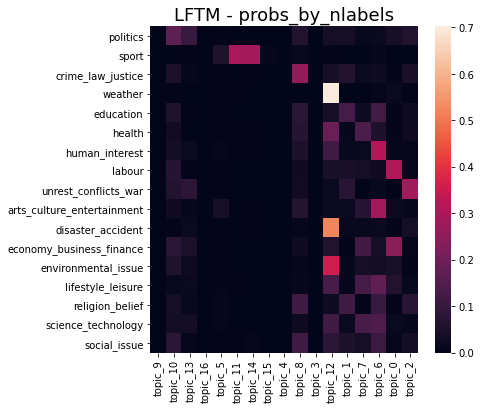

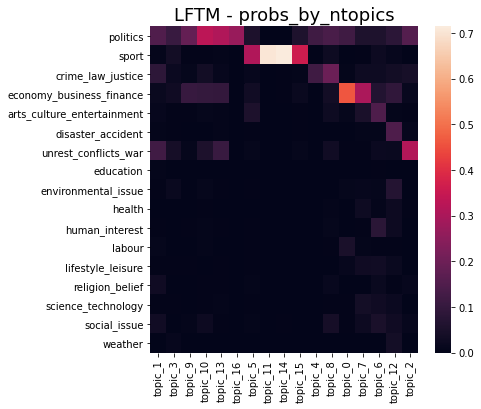

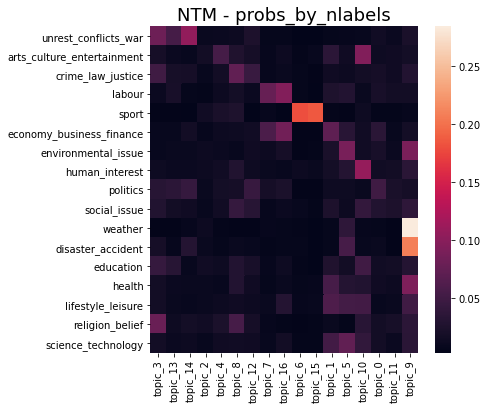

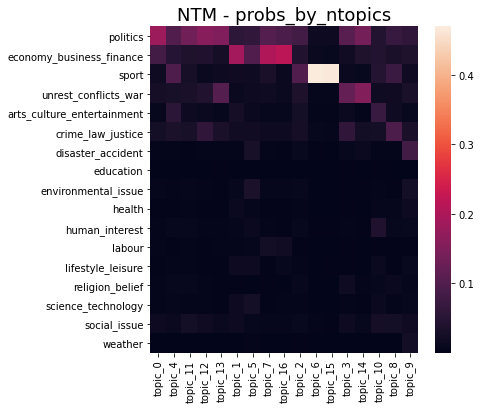

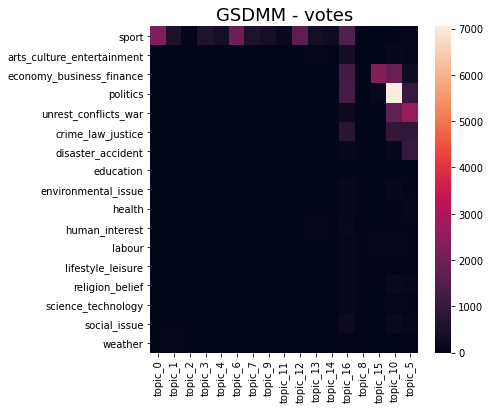

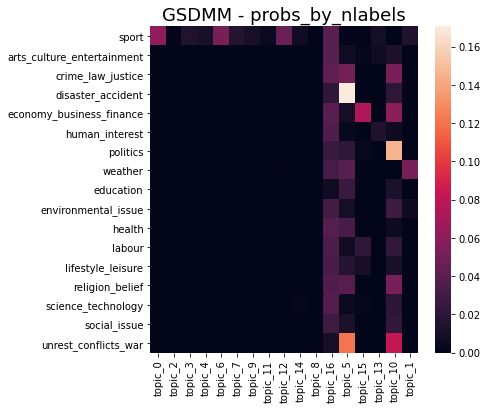

In [12]:
%%time
# We divide each score by the number of contributions (votes) for it, eliminating some overrepresentation bias
n_probs  = {model: {l: {t: probs[model][l][t]/max(votes[model][l][t], 1) for t in topics} for l in range(n_labels)} for model in models}
# We divide each score by the number documents originally in that label,  eliminating some overrepresentation bias
n2_probs = {model: {l: {t: probs[model][l][t]/docs_per_label[reverse_label_ids[l]] for t in topics} for l in range(n_labels)} for model in models}
n3_probs = {model: {l: {t: probs[model][l][t]/max(sum(votes[model][ll][t] for ll in range(n_labels)), 1) for t in topics} for l in range(n_labels)} for model in models}


# Normalizations
# n_probs  = {model: {l: {t: probs[model][l][t]/max(votes[model][l][t], 1) for t in topics} for l in range(n_labels)} for model in models}
# n2_probs = {model: {l: {t: probs[model][l][t]/docs_per_label[reverse_label_ids[l]] for t in topics} for l in range(n_labels)} for model in models}
# n3_probs = {model: {l: {t: probs[model][l][t]/predictions[f'{model}_topic_1'].value_counts()[t] for t in topics} for l in range(n_labels)} for model in models}
# n4_probs = {model: {l: {t: probs[model][l][t]/math.sqrt(docs_per_label[reverse_label_ids[l]]) for t in topics} for l in range(n_labels)} for model in models}

topic_dfs = {}
topic_mappings = {}
reverse_topic_mappings = {}
scoring_methods = {'votes': votes, 'probs': probs, 'probs_by_nvotespertopic': n_probs, 'probs_by_nlabels': n2_probs, 'probs_by_ntopics': n3_probs,} 

for model in models: 
  topic_dfs[model] = {}
  topic_mappings[model] = {}
  reverse_topic_mappings[model] = {}
  topics_json = json.load(open(model+'_topics_afp.json', 'r'))
  labels = [reverse_label_ids[t] for t in topics]

  for sm, scores in scoring_methods.items():
    topic_mapping = {}
    reverse_topic_mapping = {l:[] for l in labels}
  
    df = pd.DataFrame(scores[model]).transpose()
    df.columns = ['topic_' + str(t) for t in topics]
    df.index = labels

    for topic_id, topic in enumerate(df.columns):
      label_max = df[topic].idxmax()
      topic_mapping[topic_id] = label_max
      reverse_topic_mapping[label_max].append(topic_id)
    
    topic_mappings[model][sm] = topic_mapping
    reverse_topic_mappings[model][sm] = reverse_topic_mapping

    # For visualization purposes, we sort the Y-axis labels according to the number of topics mapped to them
    sorted_idx     = [l for l, ll in sorted(reverse_topic_mapping.items(), key=lambda x: len(x[1]), reverse=True)]
    # Then we sort the topics according to the label they map to
    sorted_columns = []
    for l in sorted_idx:
      sorted_columns.extend(['topic_'+str(t) for t in reverse_topic_mapping[l]])
    
    df_sorted = df[sorted_columns].loc[sorted_idx]
    topic_dfs[model][sm] = df_sorted
 
    plt.figure(figsize=(6, 6))
    plt.title(model.upper() + ' - ' + sm, fontsize =18)
    sn.heatmap(df_sorted).get_figure().savefig(f"{model}_{sm}_topics.png")

# Evaluations

We show the label assigned to each topic (represented by its ID and keywords) 
(We only use `probs` scores to make the 

In [0]:
# We load the list of terms per topic for each model
topic_keywords = {}
for model in models:
  topics_json = json.load(open(model+'_topics_afp.json', 'r'))
  topic_keywords[model] = {t: ', '.join(key for key in topics_json[str(t)]['words']) for t in topics}

We visualize the mapping between the labels and the topics (represented by their id and top words)

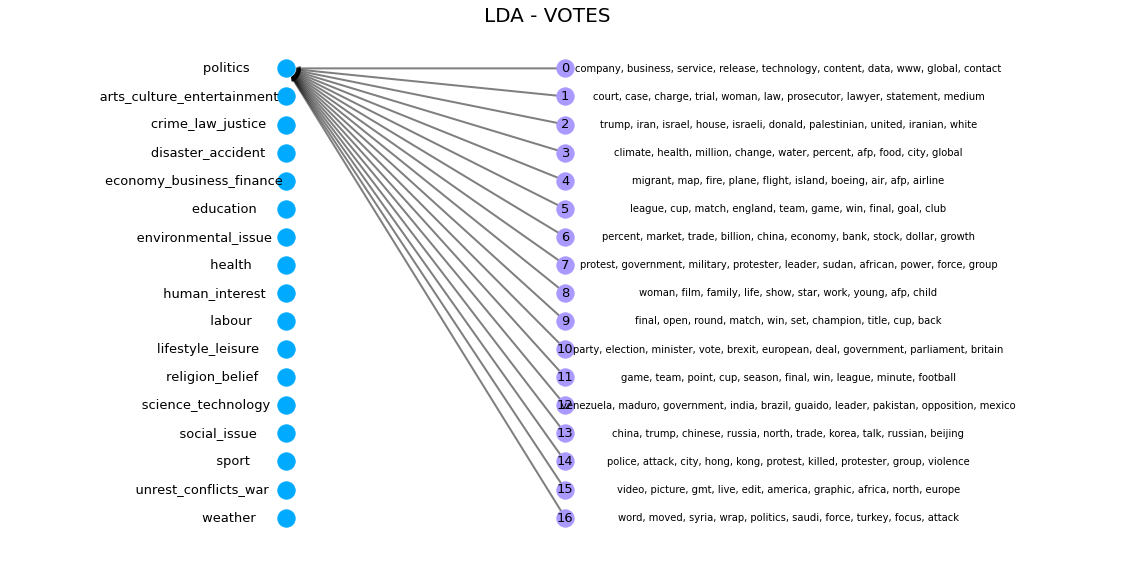

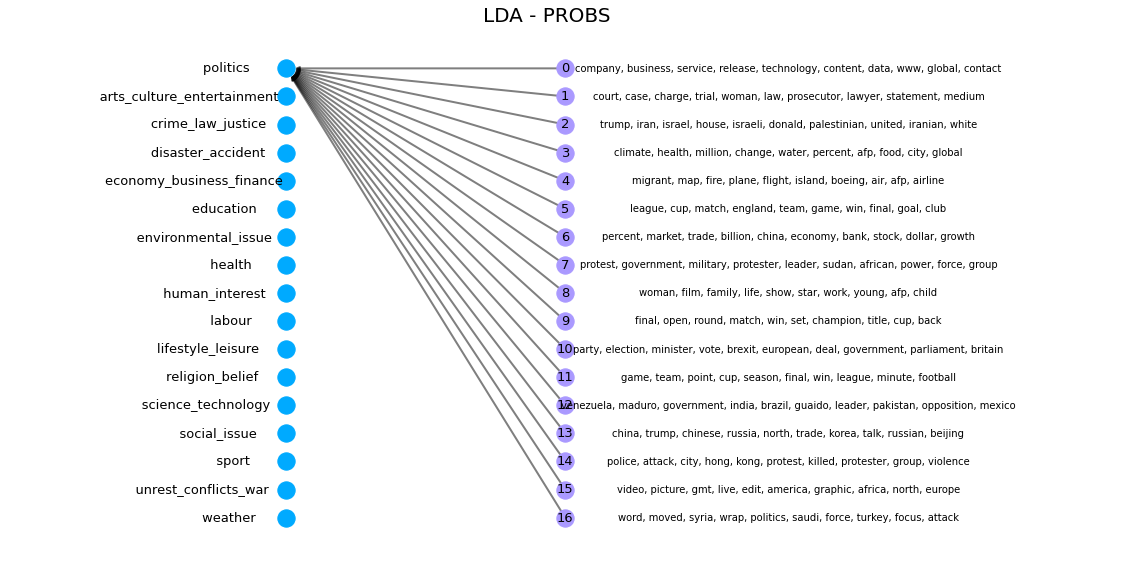

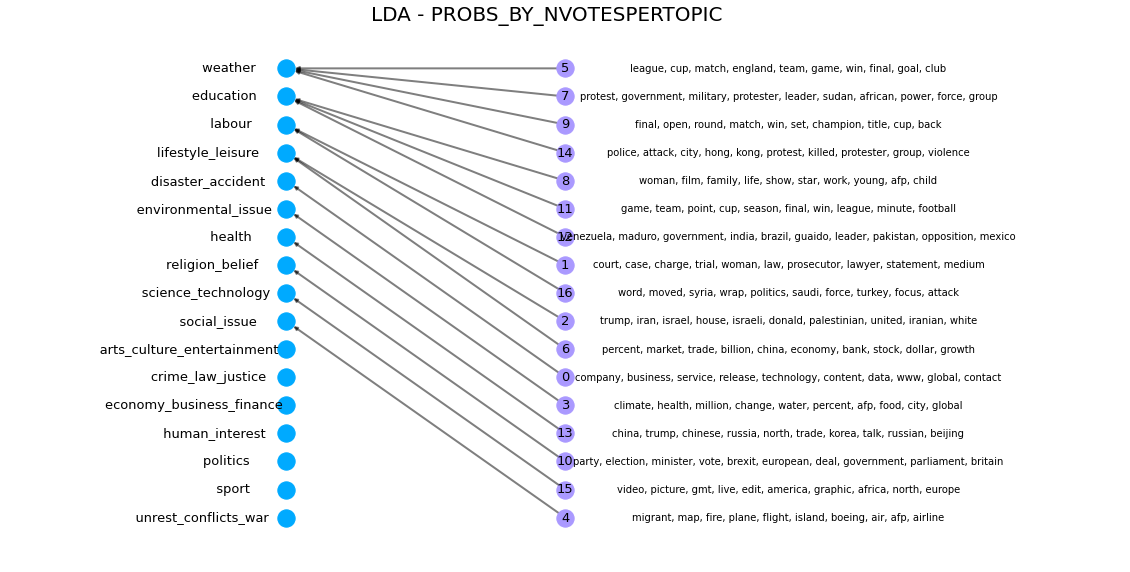

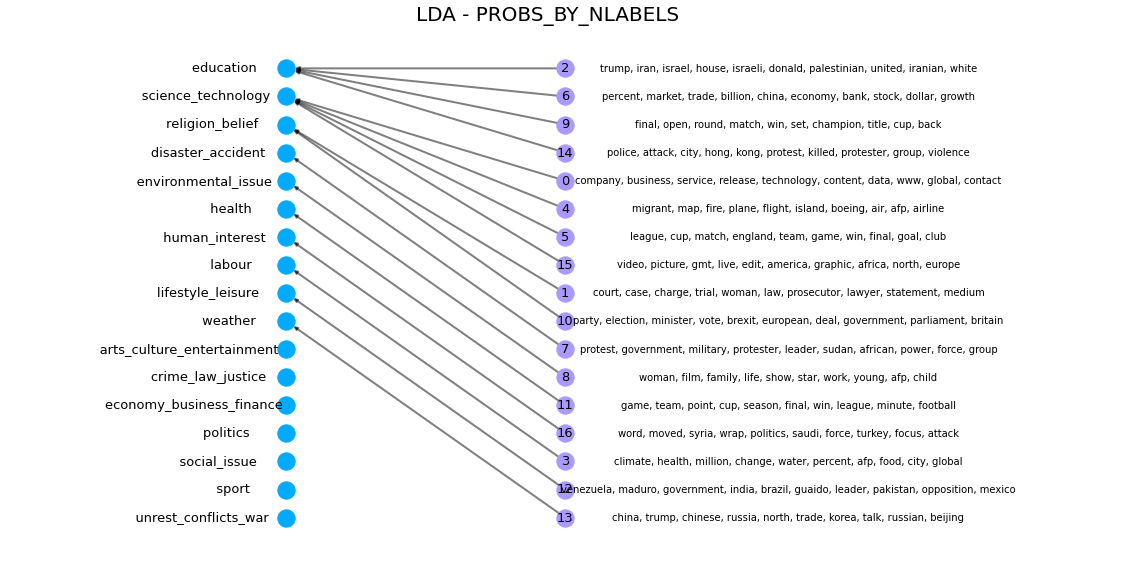

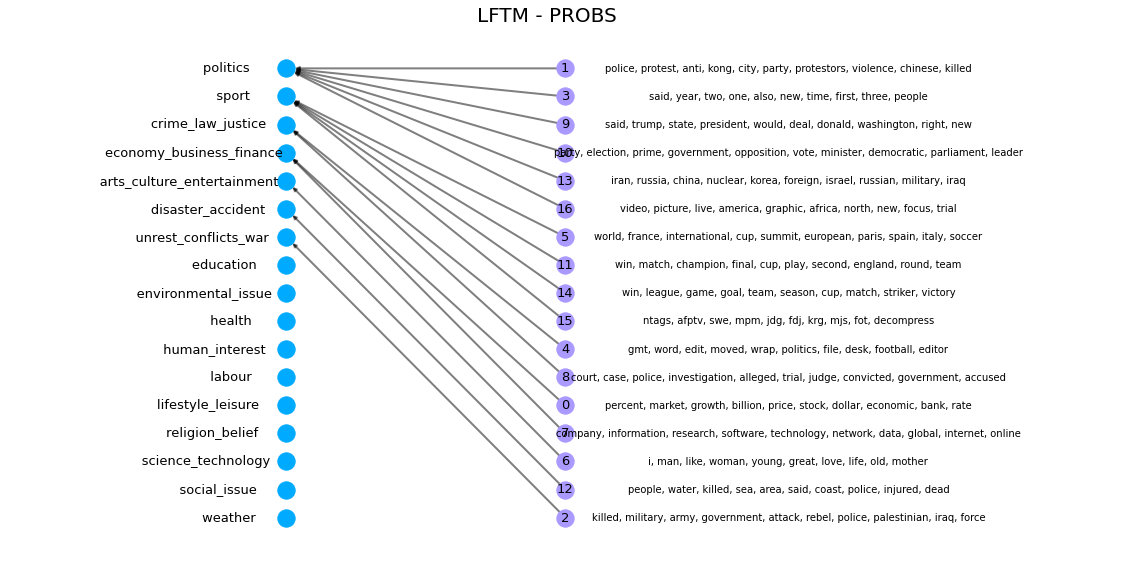

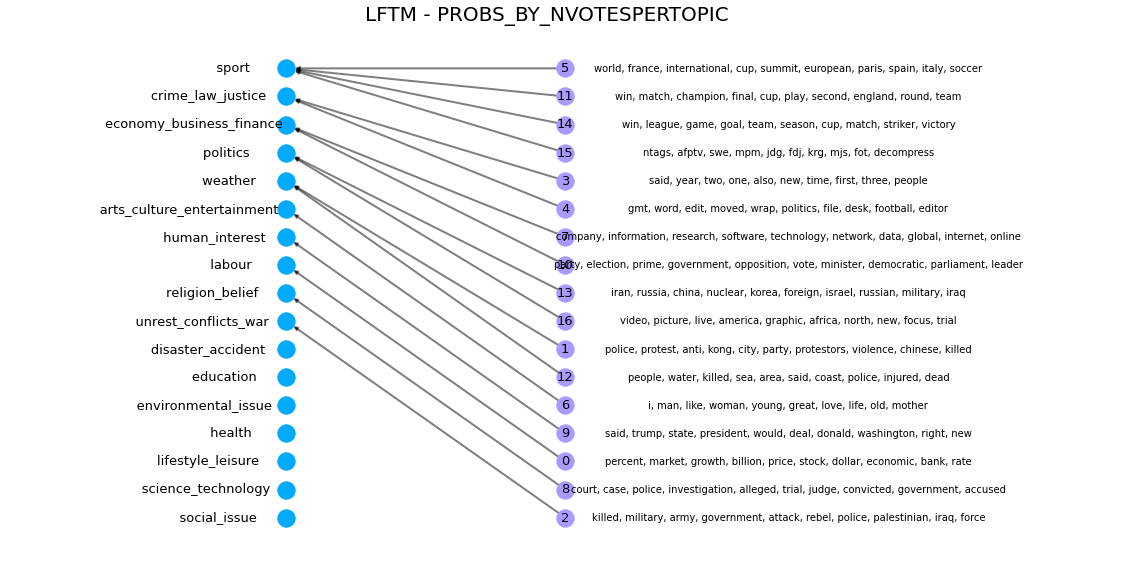

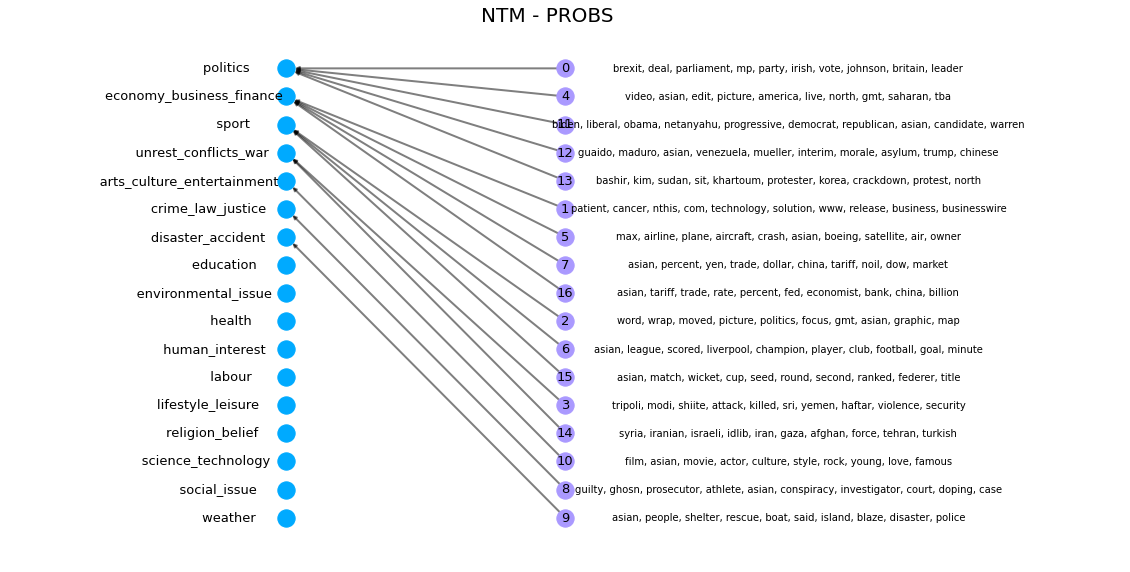

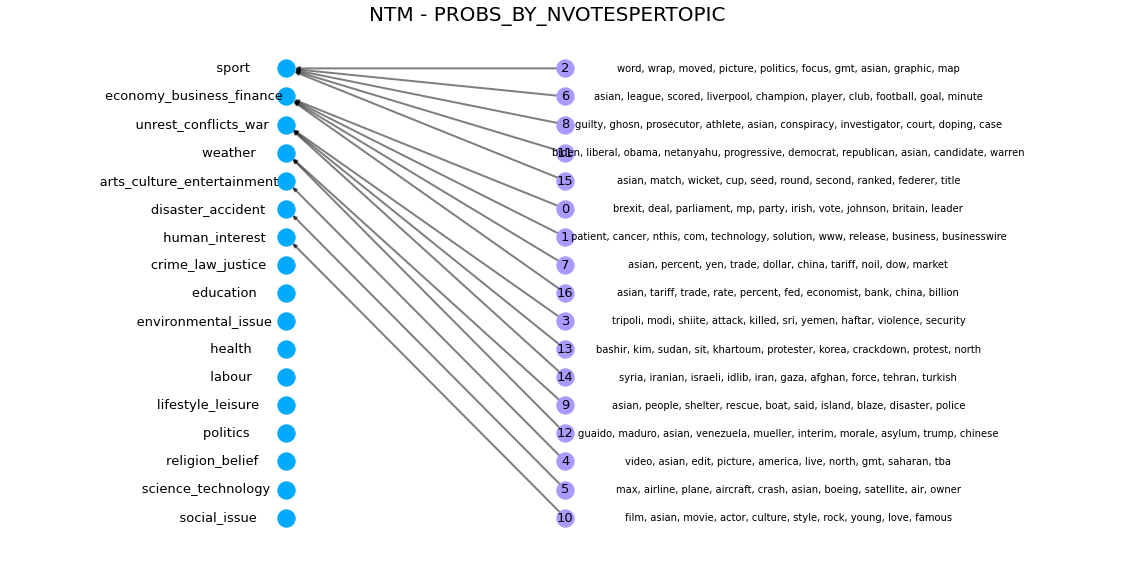

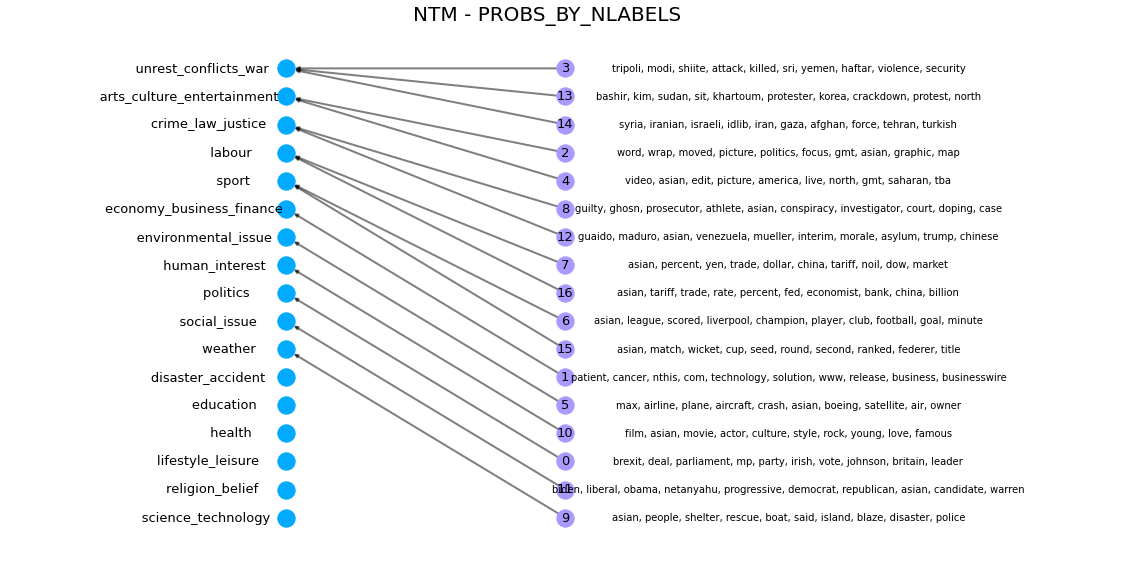

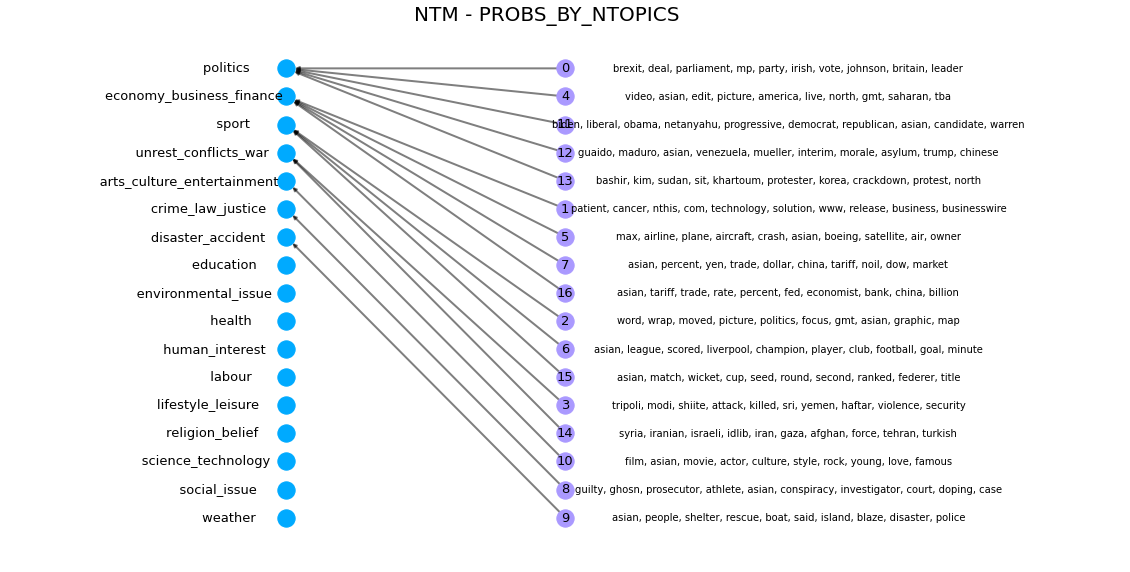

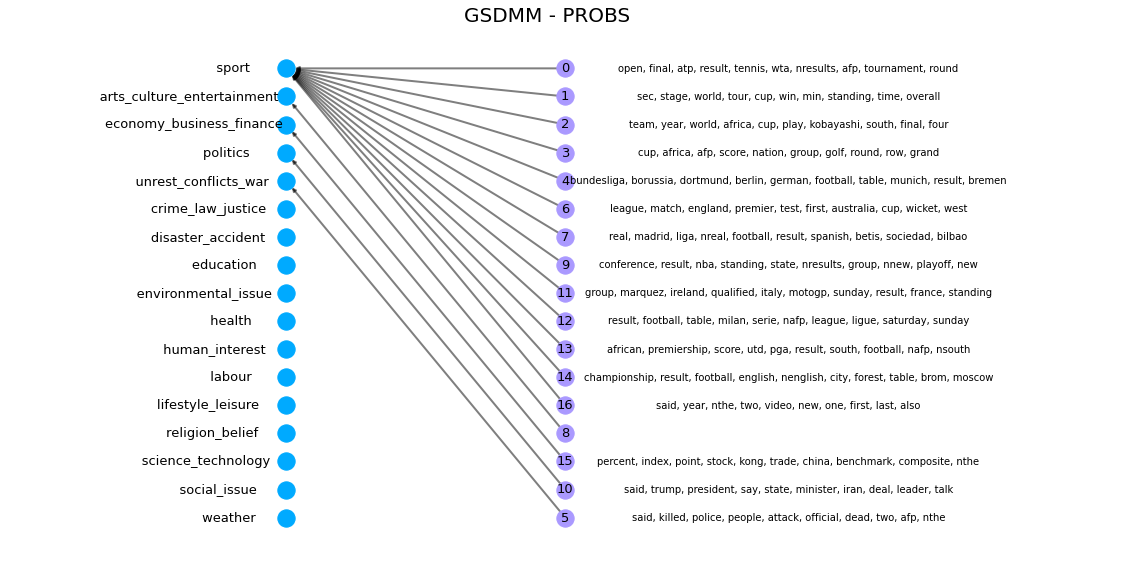

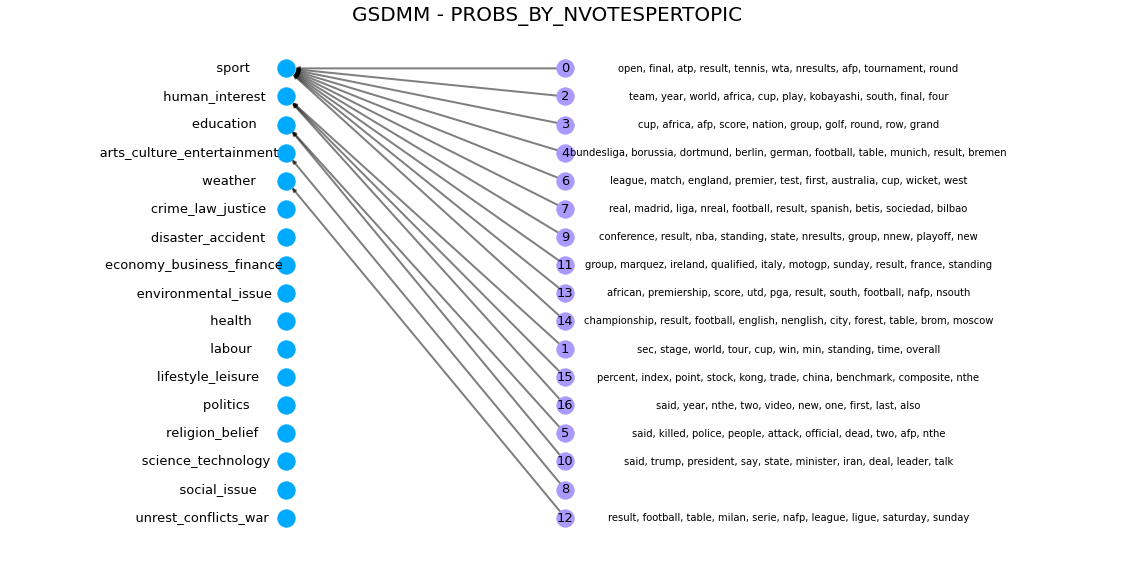

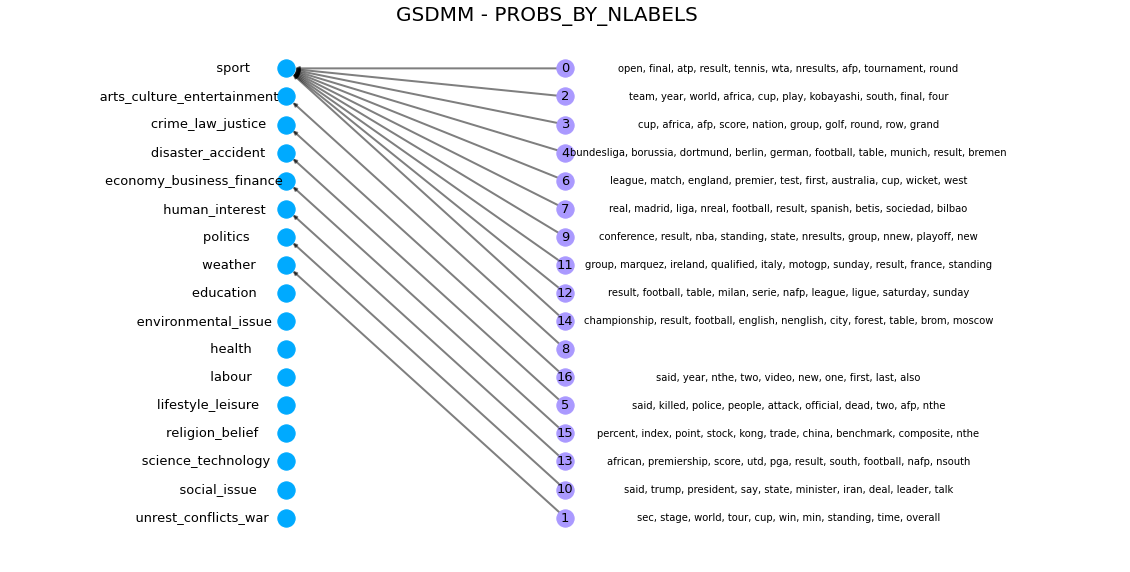

In [14]:
for model in models:
  for sm in topic_mappings[model]:
    m = topic_mappings[model][sm]
    topic_ids, mapped_labels = m.keys(), set(m.values())
    edges = m.items()

    fig, ax = plt.subplots(figsize=(20,10)) 
    ax.axis('off')

    G = nx.DiGraph()
    G.add_nodes_from(topic_ids, bipartite=0)
    G.add_nodes_from(mapped_labels, bipartite=1)
    G.add_edges_from(edges)

    # Set the position of each node on the graph
    pos = {}
    # We use the same ordering in the Scoring Visualization just to make it look pretty :) -no edges will intersect-
    ordered_labels = [l for l in topic_dfs[model][sm].index if l in mapped_labels] 
    ordered_labels = ordered_labels + [l for l in labels if l not in ordered_labels]
    ordered_topics = [int(i.split('_')[1]) for i in topic_dfs[model][sm].columns]
    pos.update((node, (0.5, n_topics - 1 - index)) for index, node in enumerate(ordered_labels))
    pos.update((node, (1.5, n_topics - 1 - index)) for index, node in enumerate(ordered_topics))

    # nx.draw(G, pos, with_labels=False)
    nx.draw_networkx_nodes(G,pos,
                            nodelist=ordered_labels,# mapped_labels,
                            node_size=300,
                            node_color='#0af')
    
    nx.draw_networkx_nodes(G,pos,
                            nodelist= topic_ids,
                            node_size=300,
                            node_color='#a9f')
    

    nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', width=2, arrowsize=7, edge_color='#000', alpha=0.5)

    pos_keywords = {k: (v[0]+0.8, v[1]) for k, v in pos.items()}
    pos_labels   = {k: (v[0]-0.45, v[1]) for k, v in pos.items()}

    nx.draw_networkx_labels(G,pos_labels, {l:str.rjust(l, 40) for l in ordered_labels},font_size=13) #mapped_labels},font_size=13)
    nx.draw_networkx_labels(G,pos, {t:t for t in topic_ids},font_size=13)
    nx.draw_networkx_labels(G,pos_keywords, topic_keywords[model],font_size=10)

    fig.suptitle(model.upper() + ' - ' + sm.upper(), fontsize=20, y=0.9)
    plt.xlim(-0.5, 3.5)
    plt.savefig(f'{model}_mapping_{sm}.png')
    plt.show()

In [18]:
metrics = ['r1_accuracy', 'r3_accuracy', 'homogeneity', 'completeness', 'v_measure', 'purity', 'average']
scores  = {}

for sm in scoring_methods:
  print('Scoring model:', sm.upper())
  for model in models:
    score   = {}
    topic_to_label = lambda t: '' if t == -1 else topic_mappings[model][sm][t]
    y_true    = predictions['true']
    y_first   = predictions['true'].apply(lambda l: l.split(' ')[0])
    y_pred_1  = predictions[model+'_topic_0'].apply(topic_to_label)
    y_pred_2  = predictions[model+'_topic_1'].apply(topic_to_label)
    y_pred_3  = predictions[model+'_topic_2'].apply(topic_to_label)

    y_pred = []
    y_pred_r3 = []
    for i, labels in y_true.to_dict().items():
      y_pred.append(labels if y_pred_1.loc[i] in labels.split(' ') else 'No Match')
      y_pred_r3.append(labels if (y_pred_1.loc[i] in labels.split(' ') or y_pred_2.loc[i] in labels.split(' ') or y_pred_3.loc[i] in labels.split(' ')) else 'No Match')
    contingency_matrix = skm.cluster.contingency_matrix(y_true, y_first)

    """
    y_true_mono = []
    for i, labels in y_true.to_dict().items():
      y_true_mono.append(y_pred_1[i] if y_pred_1[i] in labels else labels.split(' ')[0])
    """

    score['r1_accuracy']   = skm.accuracy_score(y_true, y_pred)
    score['r3_accuracy']   = skm.accuracy_score(y_true, y_pred_r3)
    score['homogeneity']   = skm.homogeneity_score(y_first, y_pred_1)
    score['completeness']  = skm.completeness_score(y_first, y_pred_1)
    score['v_measure']     = skm.v_measure_score(y_first, y_pred_1) # Also NMI
    score['purity']        = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
    score['average']       = np.average([s for k, s in score.items()])

    scores[model] = score

  header = 'model    ' + ' '.join(str.ljust(m, 13) for m in metrics)
  print(header)
  print('-'*len(header))
  for model in models:
    scorer = lambda model, metric: str.ljust(str(round(scores[model][metric]*100, 2))+'%', 13)
    print(model.upper(), '\t  ', ' '.join(scorer(model, metric) for metric in metrics))
  print('\n')

Scoring model: VOTES
model    r1_accuracy   r3_accuracy   homogeneity   completeness  v_measure     purity        average      
----------------------------------------------------------------------------------------------------------
LDA 	   38.76%        38.76%        0.0%          100.0%        0.0%          57.99%        39.25%       
LFTM 	   82.0%         93.38%        36.4%         40.64%        38.4%         57.99%        58.13%       
NTM 	   65.58%        83.36%        20.14%        22.73%        21.35%        57.99%        45.19%       
GSDMM 	   39.99%        42.47%        5.93%         23.96%        9.51%         57.99%        29.98%       


Scoring model: PROBS
model    r1_accuracy   r3_accuracy   homogeneity   completeness  v_measure     purity        average      
----------------------------------------------------------------------------------------------------------
LDA 	   38.76%        38.76%        0.0%          100.0%        0.0%          57.99%        39.25%   

In [0]:
metrics = ['Accuracy', 'Accuracy@3', 'Purity', 'Homogeneity', 'Completeness', 'V-Measure', 'Average']
scores  = {}
scores_print = {}
SMs  =  {'VOTES': 'SM1', 'PROBS':"SM2", 'PROBS_BY_NVOTESPERTOPIC':"SM5", 'PROBS_BY_NLABELS':"SM3", 'PROBS_BY_NTOPICS': "SM4"}

for sm in scoring_methods:
  # print('Scoring model:', sm.upper())
  for model in models:
    if model not in scores_print: scores_print[model] = []
    score   = {}
    topic_to_label = lambda t: '' if t == -1 else topic_mappings[model][sm][t]
    y_true    = predictions['true']
    y_first   = predictions['true'].apply(lambda l: l.split(' ')[0])
    y_pred_1  = predictions[model+'_topic_0'].apply(topic_to_label)
    y_pred_2  = predictions[model+'_topic_1'].apply(topic_to_label)
    y_pred_3  = predictions[model+'_topic_2'].apply(topic_to_label)

    y_pred = []
    y_pred_r3 = []
    for i, labels in y_true.to_dict().items():
      y_pred.append(labels if y_pred_1.loc[i] in labels.split(' ') else 'No Match')
      y_pred_r3.append(labels if (y_pred_1.loc[i] in labels.split(' ') or y_pred_2.loc[i] in labels.split(' ') or y_pred_3.loc[i] in labels.split(' ')) else 'No Match')
    contingency_matrix = skm.cluster.contingency_matrix(y_first, y_pred_1)

    """
    y_true_mono = []
    for i, labels in y_true.to_dict().items():
      y_true_mono.append(y_pred_1[i] if y_pred_1[i] in labels else labels.split(' ')[0])
    """

    score['Accuracy']   = skm.accuracy_score(y_true, y_pred)
    score['Accuracy@3']   = skm.accuracy_score(y_true, y_pred_r3)
    score['Homogeneity']   = skm.homogeneity_score(y_first, y_pred_1)
    score['Completeness']  = skm.completeness_score(y_first, y_pred_1)
    score['V-Measure']     = skm.v_measure_score(y_first, y_pred_1) # Also NMI
    score['Purity']        = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
    score['Average']       = np.average([s for k, s in score.items()])

    scores[model] = score

  for model in models:
    scorer = lambda model, metric: str.ljust(str(round(scores[model][metric]*100, 2))+'\%', 13)
    # print(model.upper(), '\t  ', ' '.join(scorer(model, metric) for metric in metrics))

    scores_print[model].append('& '.join([model.upper() + '  \t ', str.ljust(SMs[sm.upper()], 7), '& '.join(scorer(model, metric) for metric in metrics)]) + '\\\\')


header = 'model       &   ' + str.ljust('SM', 7)  + '& '+ '& '.join(str.ljust(m, 13) for m in metrics) + '\\\\'
print('  ', header)
print('  ', '-'*len(header))
for model in models:
  for sent in scores_print[model]:
    print('  ', sent)
  # print('  ', '-'*len(header))
  print('    \\hline')

# Greedy Top-1 assignement

CPU times: user 5.87 s, sys: 2.07 s, total: 7.94 s
Wall time: 5.69 s


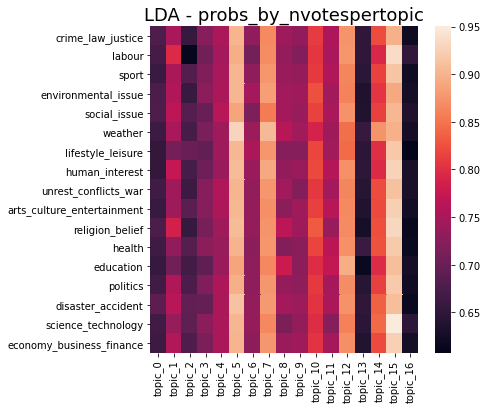

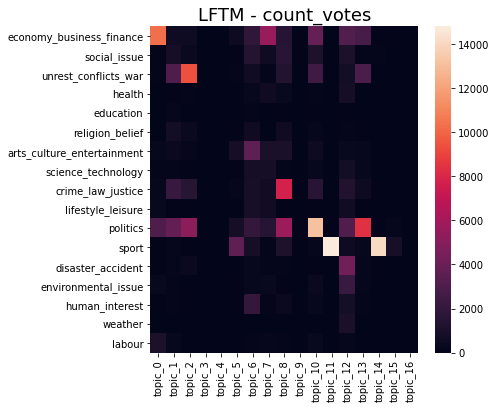

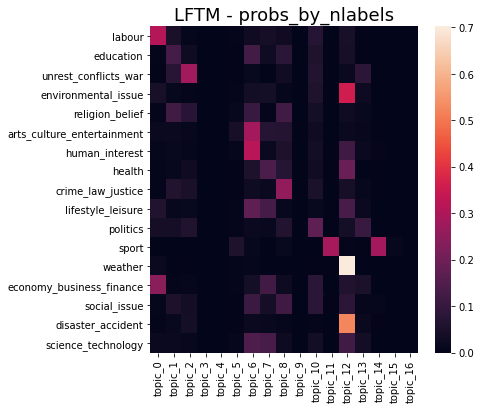

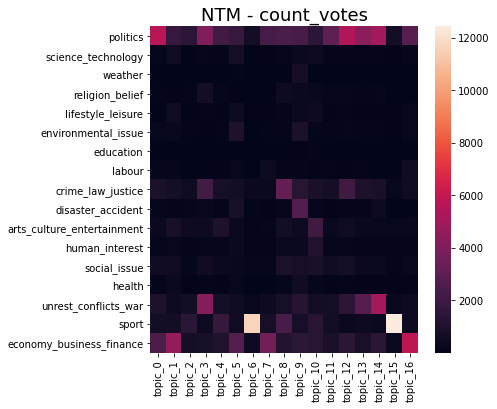

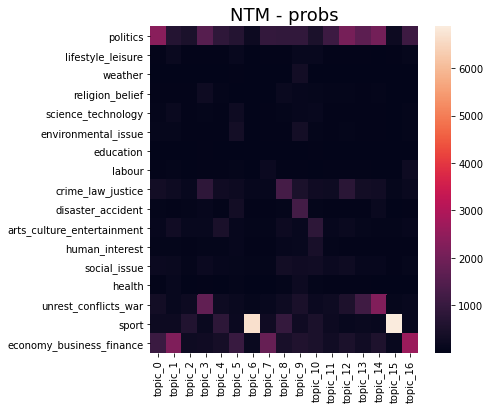

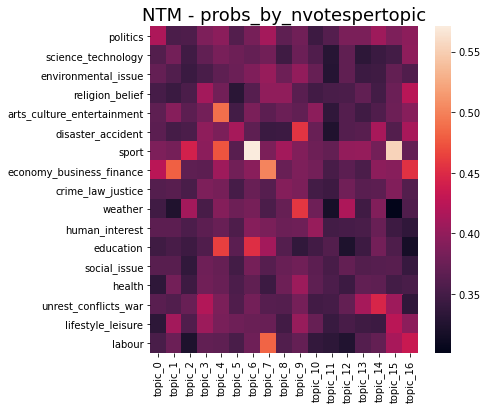

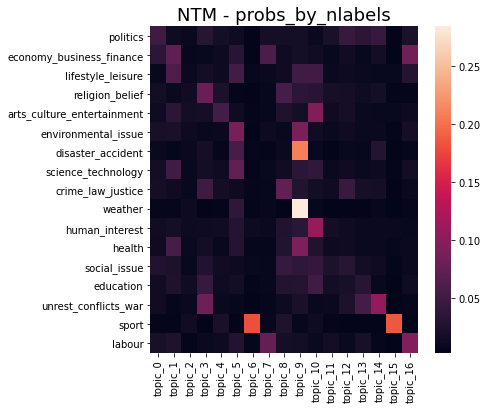

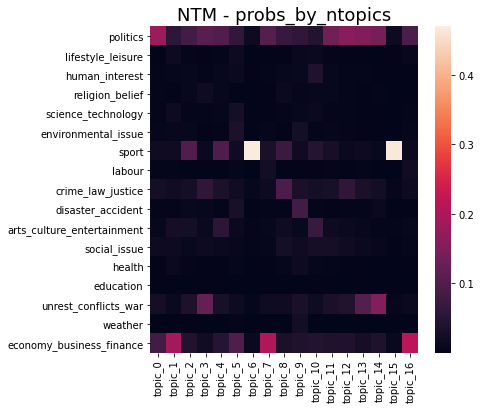

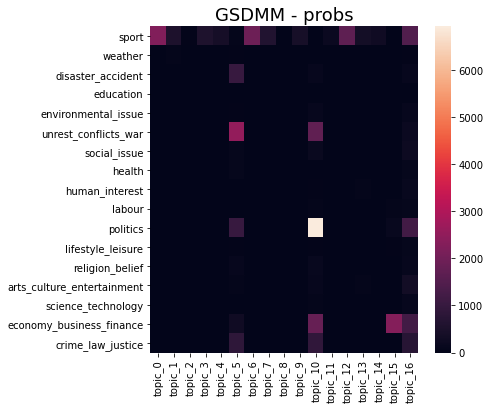

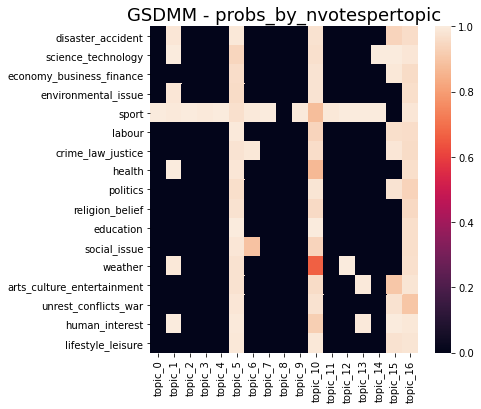

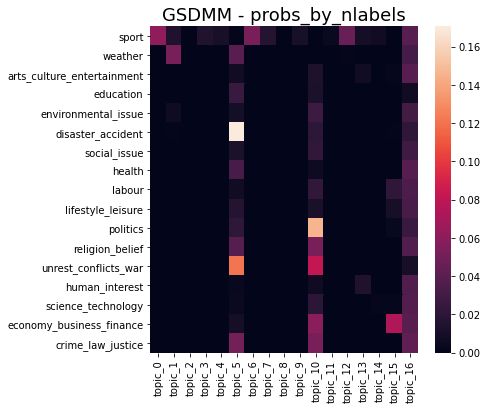

In [0]:
%%time
# We divide each score by the number of contributions (votes) for it, eliminating some overrepresentation bias
n_probs  = {model: {l: {t: probs[model][l][t]/max(votes[model][l][t], 1) for t in topics} for l in range(n_labels)} for model in models}
# We divide each score by the number documents originally in that label,  eliminating some overrepresentation bias
n2_probs = {model: {l: {t: probs[model][l][t]/docs_per_label[reverse_label_ids[l]] for t in topics} for l in range(n_labels)} for model in models}
n3_probs = {model: {l: {t: probs[model][l][t]/max(sum(votes[model][ll][t] for ll in range(n_labels)), 1) for t in topics} for l in range(n_labels)} for model in models}

topic_dfs = {}
topic_mappings = {}
reverse_topic_mappings = {}
scoring_methods = {'count_votes': votes, 'probs': probs, 'probs_by_nvotespertopic': n_probs, 'probs_by_nlabels': n2_probs, 'probs_by_ntopics': n3_probs,}

for model in models: 
  topic_dfs[model] = {}
  topic_mappings[model] = {}
  reverse_topic_mappings[model] = {}
  topics_json = json.load(open(model+'_topics_afp.json', 'r'))
  labels = [reverse_label_ids[t] for t in topics]

  for sm, scores in scoring_methods.items():
    topic_mapping = {}
    reverse_topic_mapping = {}
  
    df = pd.DataFrame(scores[model]).transpose()
    df.columns = topics # ['topic_' + str(t) for t in topics]
    df.index = labels

    flat_topic_matrix = []
    for label, score in df.iterrows():
      flat_topic_matrix.extend([(topic, label, score[topic]) for topic in topics])

    sorted_flat_topic_matrix = sorted(flat_topic_matrix, key=lambda t: t[2], reverse=True)
    # greedy_mappings[method] : 
    for t in sorted_flat_topic_matrix:
      if t[0] not in topic_mapping and t[1] not in reverse_topic_mapping:
        topic_mapping[t[0]] = t[1]
        reverse_topic_mapping[t[1]] = t[0]

      if len(topic_mapping) == n_topics:
        break
    topic_mappings[model][sm] = topic_mapping
    reverse_topic_mappings[model][sm] = reverse_topic_mapping

    # For visualization purposes, we sort the Y-axis labels according to the number of topics mapped to them
    sorted_columns = topics
    sorted_idx     = [topic_mapping[t] for t in topics]
    
    df_sorted = df[sorted_columns].loc[sorted_idx]
    df_sorted = df_sorted.rename(columns={t:f'topic_{t}' for t in topics})
    topic_dfs[model][sm] = df_sorted
 
    plt.figure(figsize=(6, 6))
    plt.title(model.upper() + ' - ' + sm, fontsize =18)
    sn.heatmap(df_sorted).get_figure().savefig(f"{model}_{sm}_topics_greedy.png")

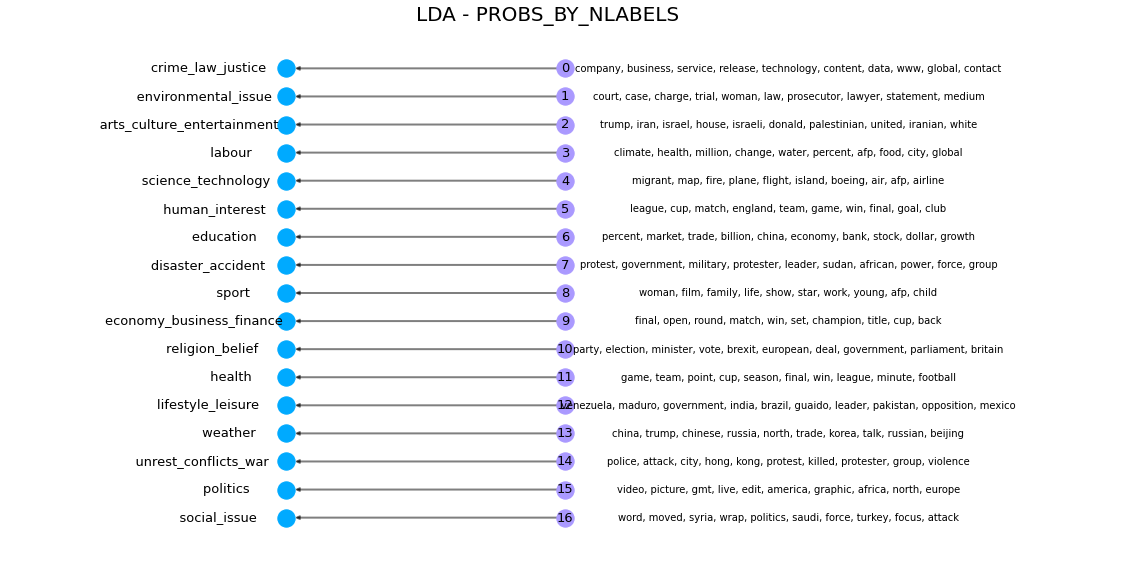

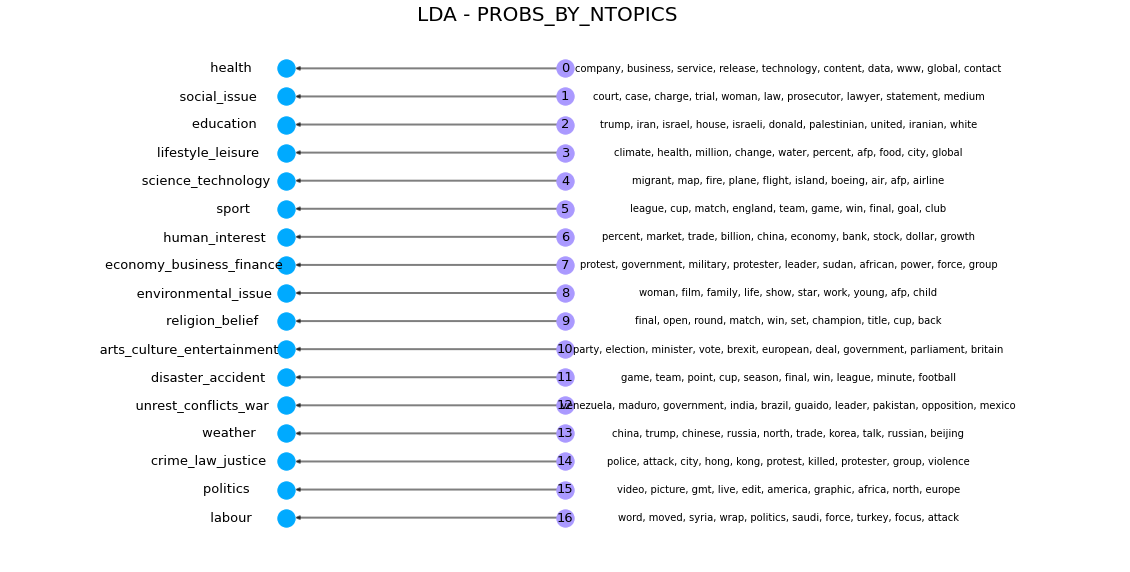

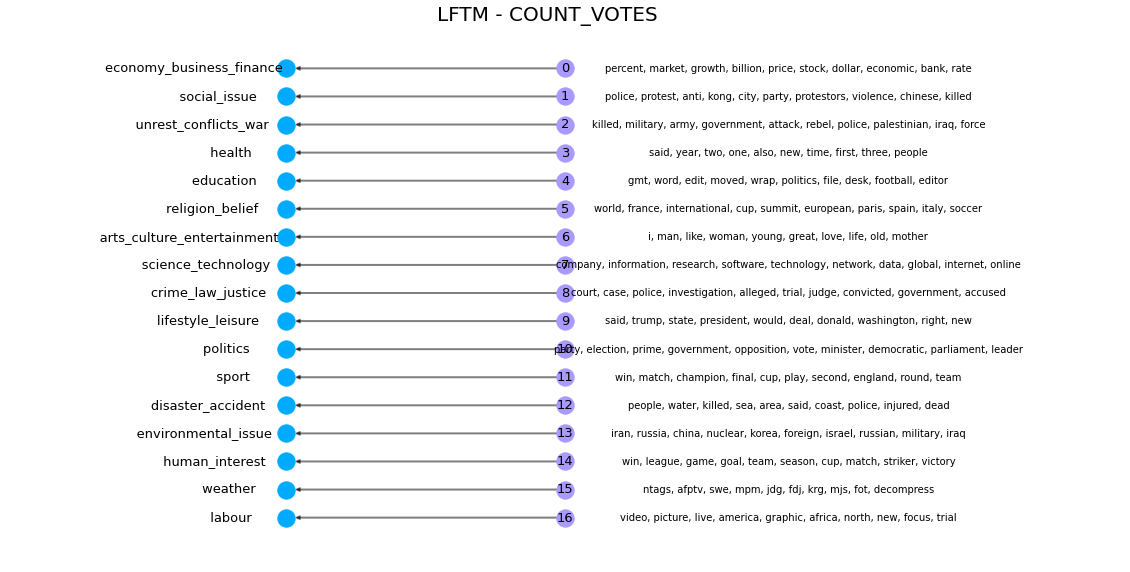

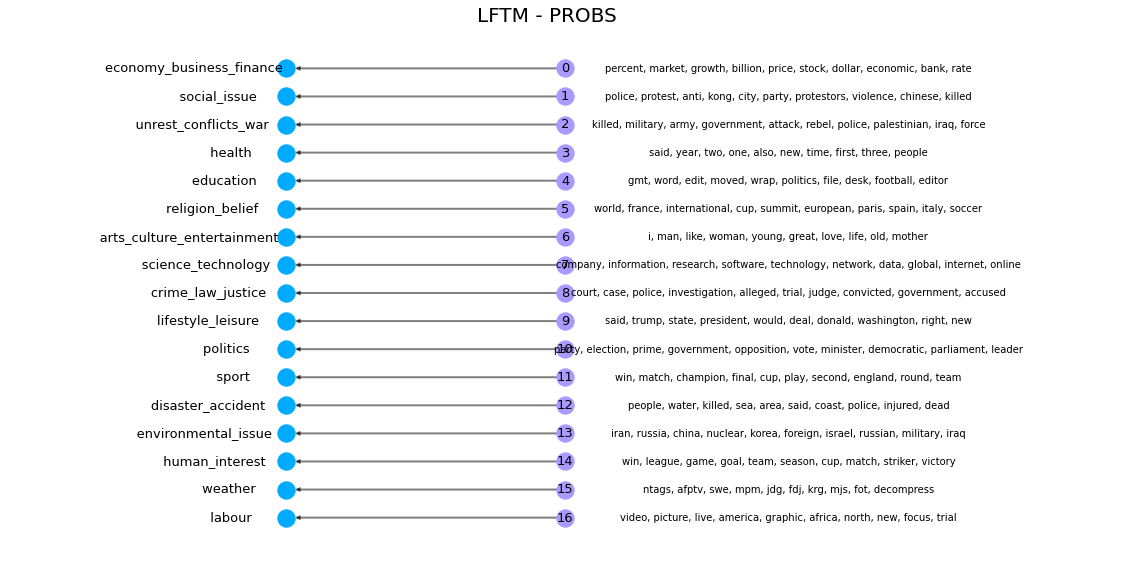

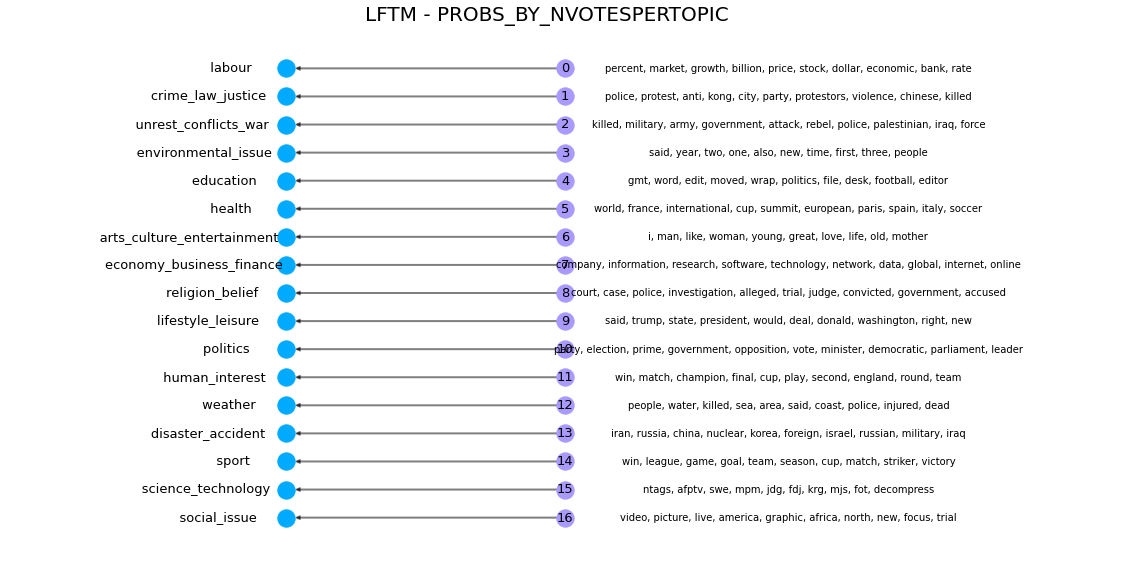

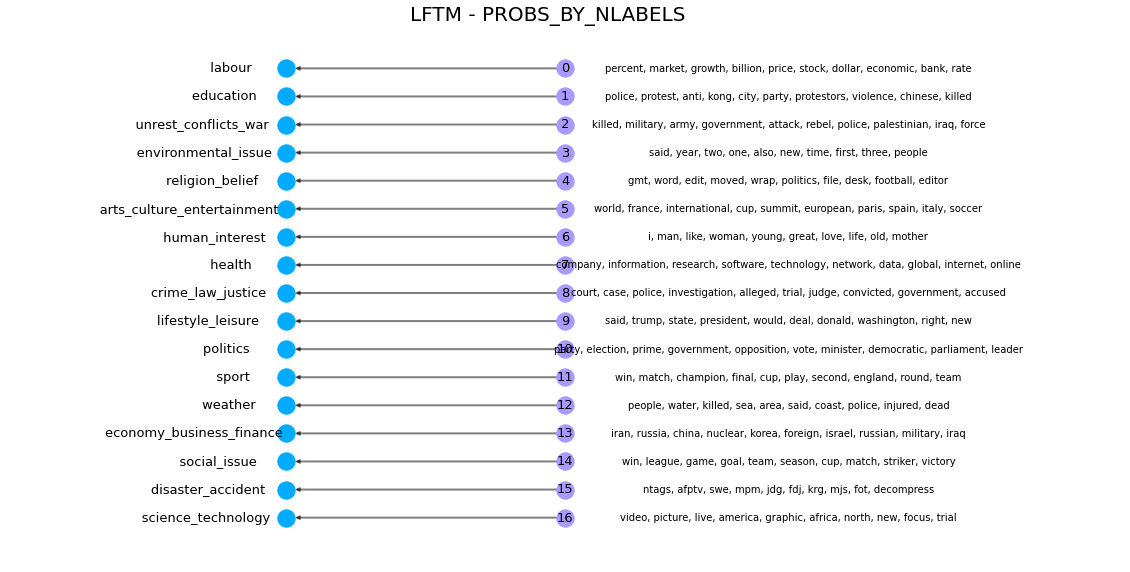

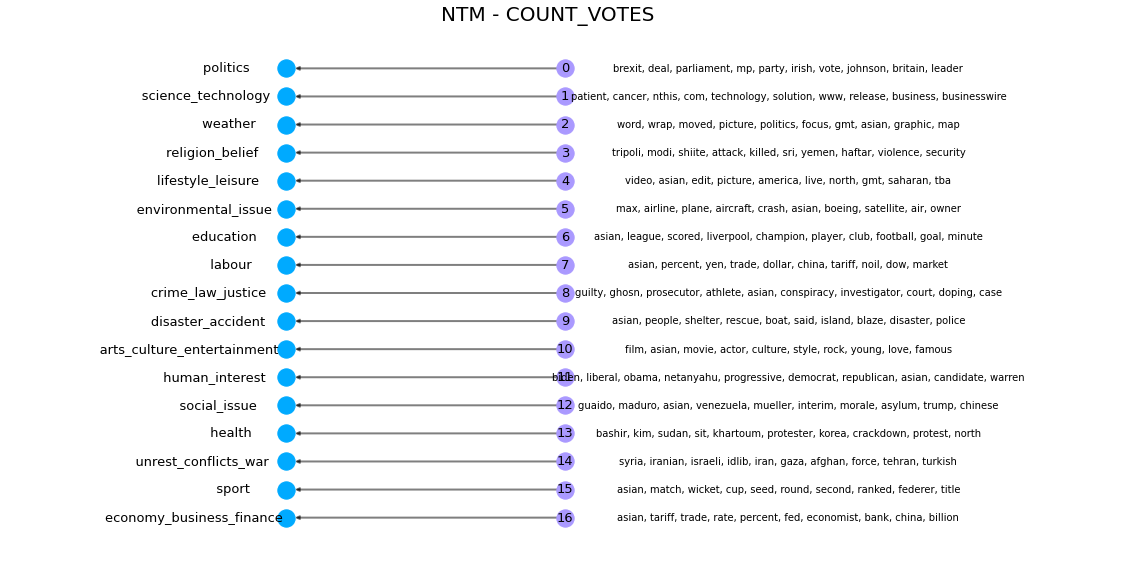

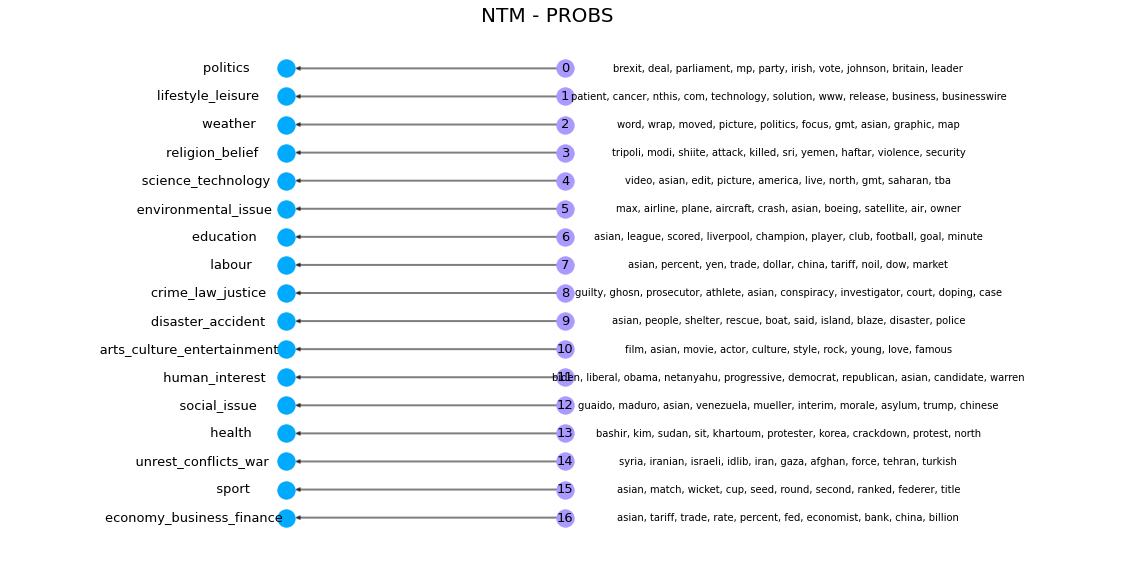

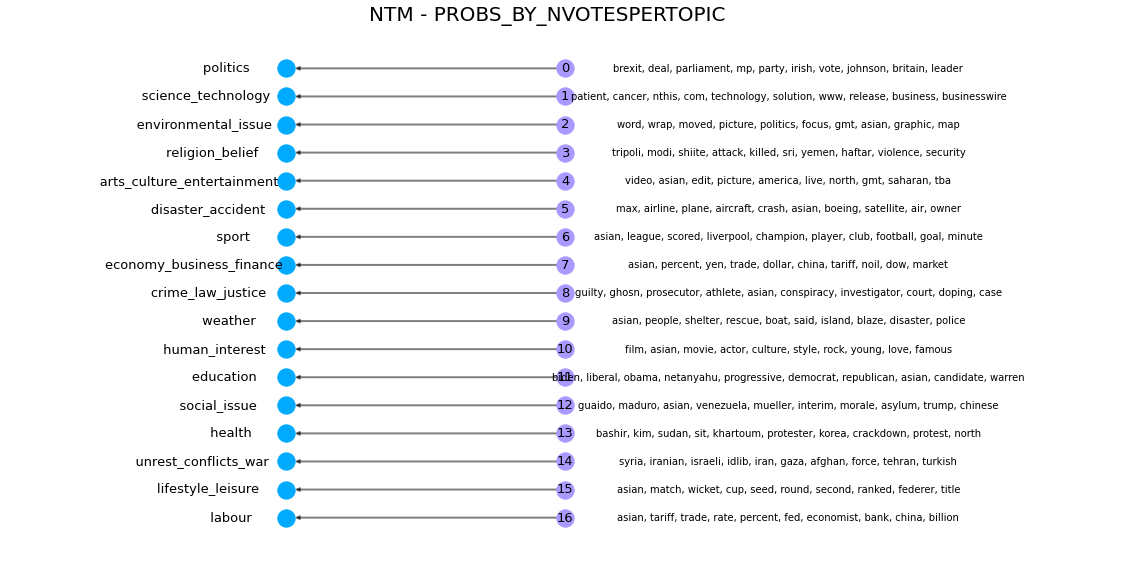

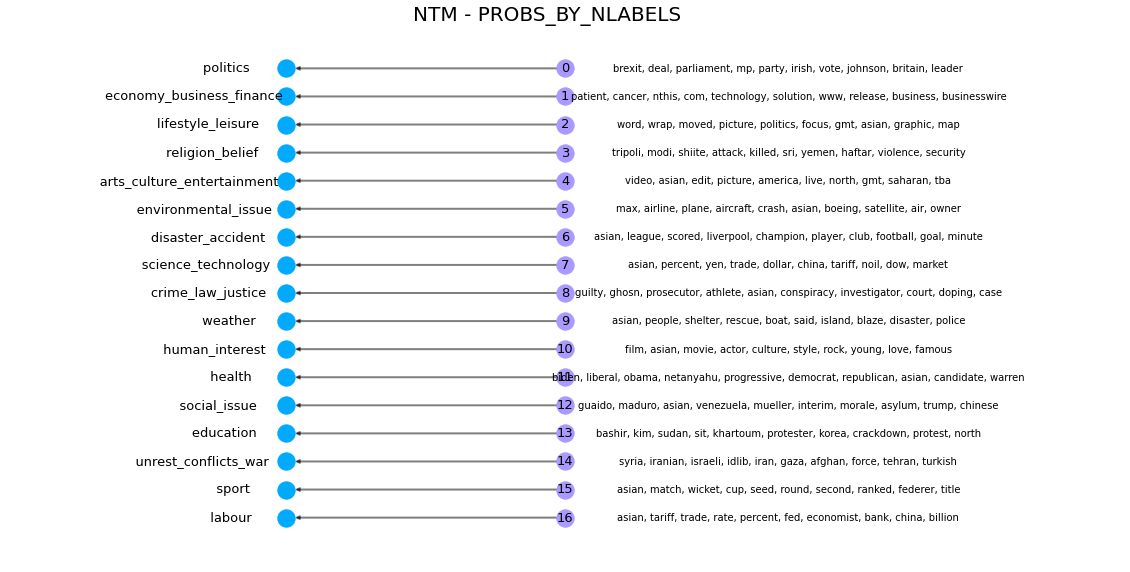

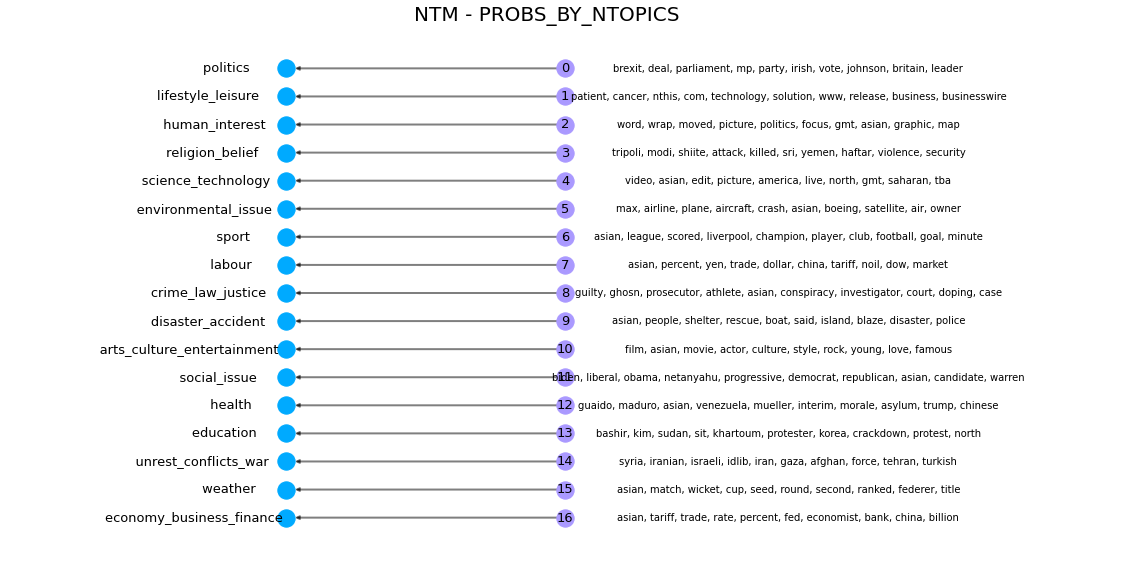

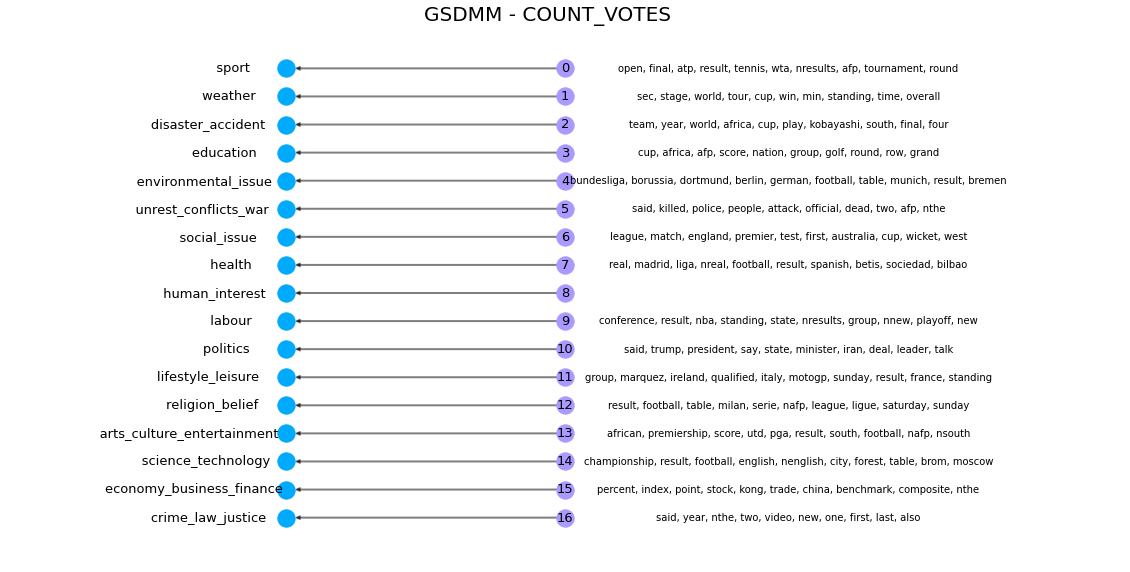

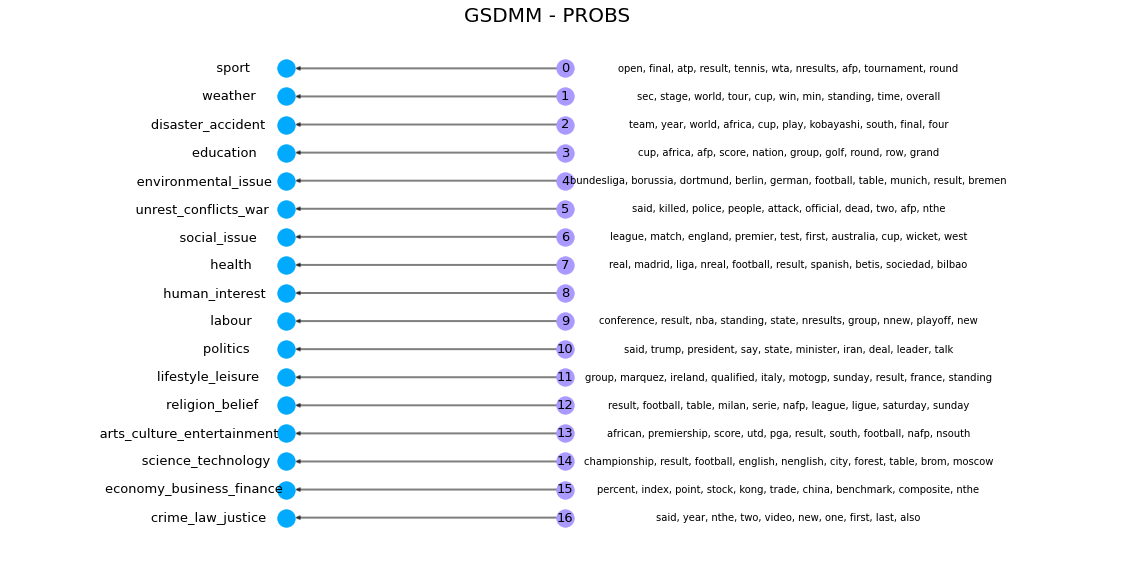

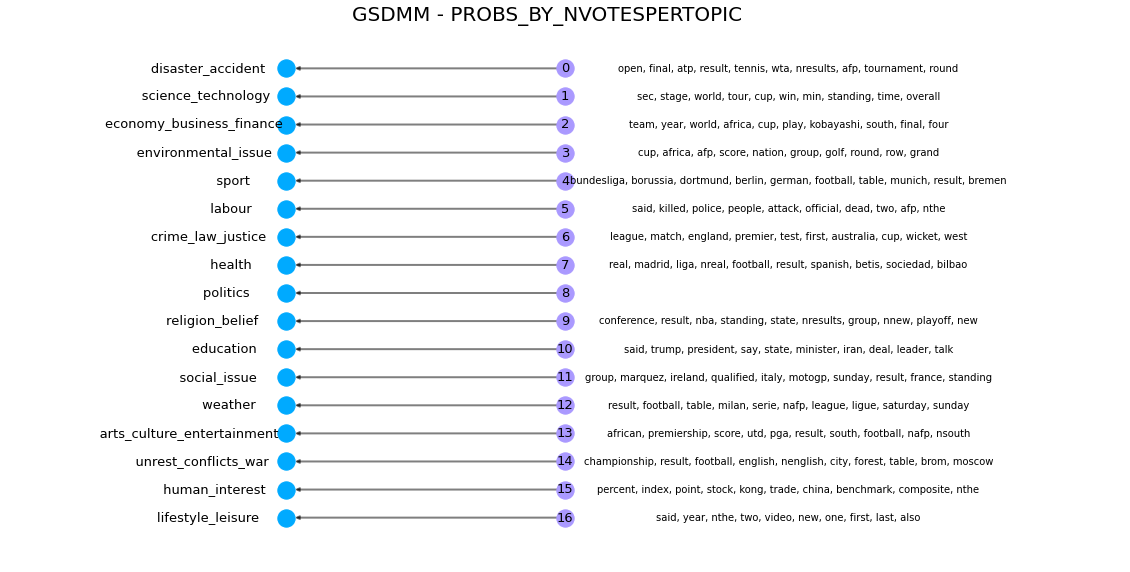

In [0]:
for model in models:
  for sm in topic_mappings[model]:
    m = topic_mappings[model][sm]
    topic_ids, mapped_labels = m.keys(), set(m.values())
    edges = m.items()

    fig, ax = plt.subplots(figsize=(20,10)) 
    ax.axis('off')

    G = nx.DiGraph()
    G.add_nodes_from(topic_ids, bipartite=0)
    G.add_nodes_from(mapped_labels, bipartite=1)
    G.add_edges_from(edges)

    # Set the position of each node on the graph
    pos = {}
    # We use the same ordering in the Scoring Visualization just to make it look pretty :) -no edges will intersect-
    ordered_labels = [l for l in topic_dfs[model][sm].index if l in mapped_labels]
    ordered_topics = [int(i.split('_')[1]) for i in topic_dfs[model][sm].columns]
    pos.update((node, (0.5, n_topics - 1 - index)) for index, node in enumerate(ordered_labels))
    pos.update((node, (1.5, n_topics - 1 - index)) for index, node in enumerate(ordered_topics))

    # nx.draw(G, pos, with_labels=False)
    nx.draw_networkx_nodes(G,pos,
                            nodelist= mapped_labels,
                            node_size=300,
                            node_color='#0af')
    
    nx.draw_networkx_nodes(G,pos,
                            nodelist= topic_ids,
                            node_size=300,
                            node_color='#a9f')
    

    nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', width=2, arrowsize=7, edge_color='#000', alpha=0.5)

    pos_keywords = {k: (v[0]+0.8, v[1]) for k, v in pos.items()}
    pos_labels   = {k: (v[0]-0.45, v[1]) for k, v in pos.items()}

    nx.draw_networkx_labels(G,pos_labels, {l:str.rjust(l, 40) for l in mapped_labels},font_size=13)
    nx.draw_networkx_labels(G,pos, {t:t for t in topic_ids},font_size=13)
    nx.draw_networkx_labels(G,pos_keywords, topic_keywords[model],font_size=10)

    fig.suptitle(model.upper() + ' - ' + sm.upper(), fontsize=20, y=0.9)
    plt.xlim(-0.5, 3.5)
    plt.savefig(f'{model}_mapping_{sm}.png')
    plt.show()

In [0]:
metrics = ['r1_accuracy', 'r3_accuracy', 'homogeneity', 'completeness', 'v_measure', 'purity', 'average']
scores  = {}

for sm in scoring_methods:
  print('Scoring model:', sm.upper())
  for model in models:
    score   = {}
    topic_to_label = lambda t: '' if t == -1 else topic_mappings[model][sm][t]
    y_true    = predictions['true']
    y_pred    = predictions[model+'_topic_0'].apply(topic_to_label)
    y_pred_2  = predictions[model+'_topic_1'].apply(topic_to_label)
    y_pred_3  = predictions[model+'_topic_2'].apply(topic_to_label)
    contingency_matrix = skm.cluster.contingency_matrix(y_true, y_pred)

    score['r1_accuracy']   = skm.accuracy_score(y_true, y_pred)
    score['r3_accuracy']   = skm.accuracy_score(y_true, y_pred) + skm.accuracy_score(y_true, y_pred_2) + skm.accuracy_score(y_true, y_pred_3)
    score['homogeneity']   = skm.homogeneity_score(y_true, y_pred)
    score['completeness']  = skm.completeness_score(y_true, y_pred)
    score['v_measure']     = skm.v_measure_score(y_true, y_pred) # Also NMI
    score['purity']        = np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 
    score['average']       = np.average([s for k, s in score.items()])

    scores[model] = score

  header = 'model    ' + ' '.join(str.ljust(m, 13) for m in metrics)
  print(header)
  print('-'*len(header))
  for model in models:
    scorer = lambda model, metric: str.ljust(str(round(scores[model][metric]*100, 2))+'%', 13)
    print(model.upper(), '\t  ', ' '.join(scorer(model, metric) for metric in metrics))
  print('\n')

Scoring model: COUNT_VOTES
model    r1_accuracy   r3_accuracy   homogeneity   completeness  v_measure     purity        average      
----------------------------------------------------------------------------------------------------------
LDA 	   5.22%         22.28%        2.26%         3.05%         2.6%          27.9%         10.55%       
LFTM 	   27.59%        36.28%        31.91%        47.32%        38.12%        48.96%        38.36%       
NTM 	   17.54%        27.09%        18.79%        24.75%        21.36%        39.52%        24.84%       
GSDMM 	   27.29%        31.32%        6.58%         24.79%        10.4%         33.93%        22.38%       


Scoring model: PROBS
model    r1_accuracy   r3_accuracy   homogeneity   completeness  v_measure     purity        average      
----------------------------------------------------------------------------------------------------------
LDA 	   5.1%          14.24%        2.26%         3.05%         2.6%          27.9%         9.1